# Prédiction du Prix de Clôture SOL/USD

# Réalisé Par: SKOURI Youssef 

# Importation Des Bibliothèques Nécessaires

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime


2025-10-28 15:48:59.308905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Récupération des Données 

#### API Utilisé : API de Yahoo Finance.

In [2]:
def fetch_data():
    df = yf.download('SOL-USD', start='2020-04-10', end=datetime.now().strftime('%Y-%m-%d'))
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

data = fetch_data()
print(data.head())
print(data.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Open      High       Low     Close    Volume
Ticker       SOL-USD   SOL-USD   SOL-USD   SOL-USD   SOL-USD
Date                                                        
2020-04-10  0.832005  1.313487  0.694187  0.951054  87364276
2020-04-11  0.951054  1.049073  0.765020  0.776819  43862444
2020-04-12  0.785448  0.956670  0.762426  0.882507  38736897
2020-04-13  0.890760  0.891603  0.773976  0.777832  18211285
2020-04-14  0.777832  0.796472  0.628169  0.661925  16747614
Price             Open        High         Low       Close      Volume
Ticker         SOL-USD     SOL-USD     SOL-USD     SOL-USD     SOL-USD
Date                                                                  
2025-10-23  180.148132  193.175568  179.800873  191.388275  6358339771
2025-10-24  191.388596  195.312332  189.108887  193.560226  5855077941
2025-10-25  193.560822  195.083359  191.603333  194.040375  3170047006
2025-10-26  194.037582  200.621216  192.160767  200.028625  4753310567
2025-10-27  200

#### Tirage Des Indicateurs : SMA10, SMA30, RSI Et Bollinger-Bands

In [3]:
def add_indicators(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_30'] = data['Close'].rolling(window=30).mean()
    
    def compute_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    data['RSI'] = compute_rsi(data['Close'])
    
    rolling_mean = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    data['Bollinger_High'] = rolling_mean + (rolling_std * 2)
    data['Bollinger_Low'] = rolling_mean - (rolling_std * 2)
    
    data.dropna(inplace=True)
    return data

data = add_indicators(data)
print(data.head())


Price           Open      High       Low     Close   Volume    SMA_10  \
Ticker       SOL-USD   SOL-USD   SOL-USD   SOL-USD  SOL-USD             
Date                                                                    
2020-05-09  0.604042  0.625429  0.588448  0.604527  2128503  0.656959   
2020-05-10  0.604461  0.612303  0.513081  0.537034  2327581  0.641558   
2020-05-11  0.536255  0.571860  0.505194  0.515273  2098481  0.620206   
2020-05-12  0.513391  0.559759  0.505251  0.538576  2198625  0.602476   
2020-05-13  0.538372  0.564874  0.518038  0.550532  2326446  0.589575   

Price         SMA_30        RSI Bollinger_High Bollinger_Low  
Ticker                                                        
Date                                                          
2020-05-09  0.674803  45.793690       0.751616      0.539154  
2020-05-10  0.661003  40.548006       0.751905      0.538687  
2020-05-11  0.652284  44.046391       0.760715      0.522639  
2020-05-12  0.640820  35.176061      

# Mise en place d'Indexation et Normalisation.

In [4]:
print("Vérification des données avant normalisation :")
print(data.head())
print(data.isnull().sum()) 

Vérification des données avant normalisation :
Price           Open      High       Low     Close   Volume    SMA_10  \
Ticker       SOL-USD   SOL-USD   SOL-USD   SOL-USD  SOL-USD             
Date                                                                    
2020-05-09  0.604042  0.625429  0.588448  0.604527  2128503  0.656959   
2020-05-10  0.604461  0.612303  0.513081  0.537034  2327581  0.641558   
2020-05-11  0.536255  0.571860  0.505194  0.515273  2098481  0.620206   
2020-05-12  0.513391  0.559759  0.505251  0.538576  2198625  0.602476   
2020-05-13  0.538372  0.564874  0.518038  0.550532  2326446  0.589575   

Price         SMA_30        RSI Bollinger_High Bollinger_Low  
Ticker                                                        
Date                                                          
2020-05-09  0.674803  45.793690       0.751616      0.539154  
2020-05-10  0.661003  40.548006       0.751905      0.538687  
2020-05-11  0.652284  44.046391       0.760715      0

In [5]:
data.reset_index(drop=True, inplace=True)
print(data.index)  
print(data.columns)  


RangeIndex(start=0, stop=1998, step=1)
MultiIndex([(          'Open', 'SOL-USD'),
            (          'High', 'SOL-USD'),
            (           'Low', 'SOL-USD'),
            (         'Close', 'SOL-USD'),
            (        'Volume', 'SOL-USD'),
            (        'SMA_10',        ''),
            (        'SMA_30',        ''),
            (           'RSI',        ''),
            ('Bollinger_High',        ''),
            ( 'Bollinger_Low',        '')],
           names=['Price', 'Ticker'])


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 3])  
    return np.array(X), np.array(y)

sequence_length = 56
X, y = create_sequences(scaled_data, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Tableau de Statistiques (Format .csv)

In [7]:
stats = data.describe().T 
stats['Variance'] = data.var() 
print("Statistiques descriptives :")
print(stats)

stats.to_csv("statistiques_descriptives.csv")


Statistiques descriptives :
                         count          mean           std            min  \
Price          Ticker                                                       
Open           SOL-USD  1998.0  8.560982e+01  7.450677e+01       0.513391   
High           SOL-USD  1998.0  8.885178e+01  7.699920e+01       0.559759   
Low            SOL-USD  1998.0  8.240979e+01  7.190716e+01       0.505194   
Close          SOL-USD  1998.0  8.569356e+01  7.450415e+01       0.515273   
Volume         SOL-USD  1998.0  2.215956e+09  2.684708e+09  652020.000000   
SMA_10                  1998.0  8.525905e+01  7.410195e+01       0.569183   
SMA_30                  1998.0  8.427004e+01  7.322911e+01       0.586244   
RSI                     1998.0  5.227660e+01  1.715400e+01       9.680616   
Bollinger_High          1998.0  9.956388e+01  8.532731e+01       0.644876   
Bollinger_Low           1998.0  7.000507e+01  6.308052e+01       0.484328   

                                 25%           

# Visualisation des indicateurs (courbes)

#### Courbes pour SMA, RSI, et Bollinger Bands

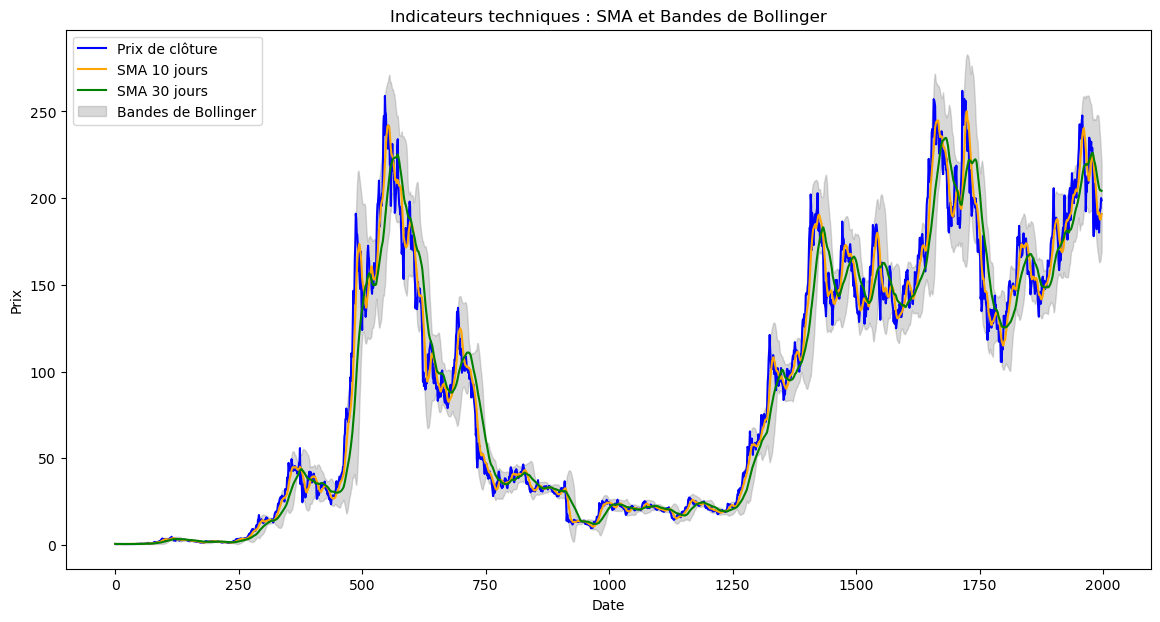

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Prix de clôture', color='blue')
plt.plot(data.index, data['SMA_10'], label='SMA 10 jours', color='orange')
plt.plot(data.index, data['SMA_30'], label='SMA 30 jours', color='green')
plt.fill_between(data.index, data['Bollinger_Low'], data['Bollinger_High'], color='grey', alpha=0.3, label='Bandes de Bollinger')
plt.title('Indicateurs techniques : SMA et Bandes de Bollinger')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()


#### Courbe pour RSI

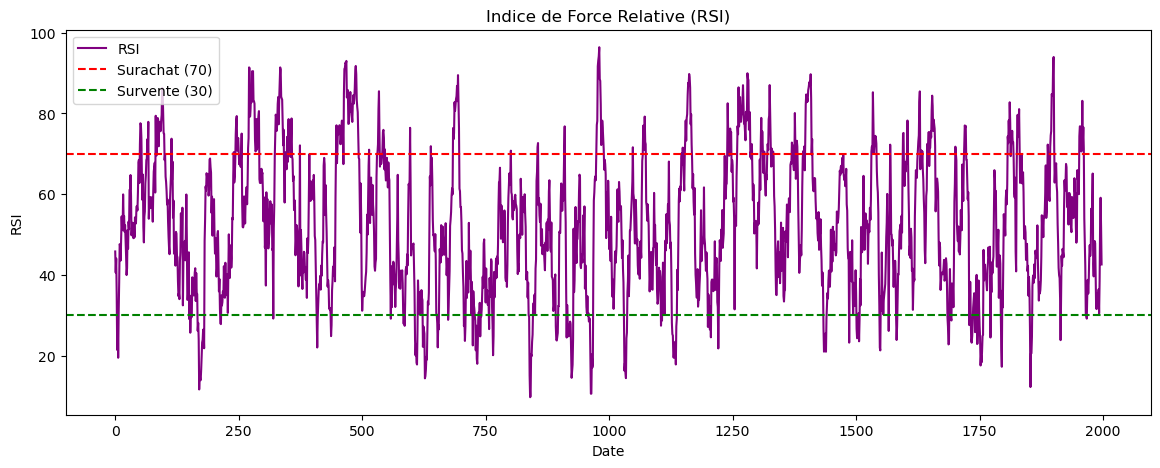

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Surachat (70)')
plt.axhline(30, color='green', linestyle='--', label='Survente (30)')
plt.title('Indice de Force Relative (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

## Histogrammes des distributions des données

#### Histogramme des prix de clôture



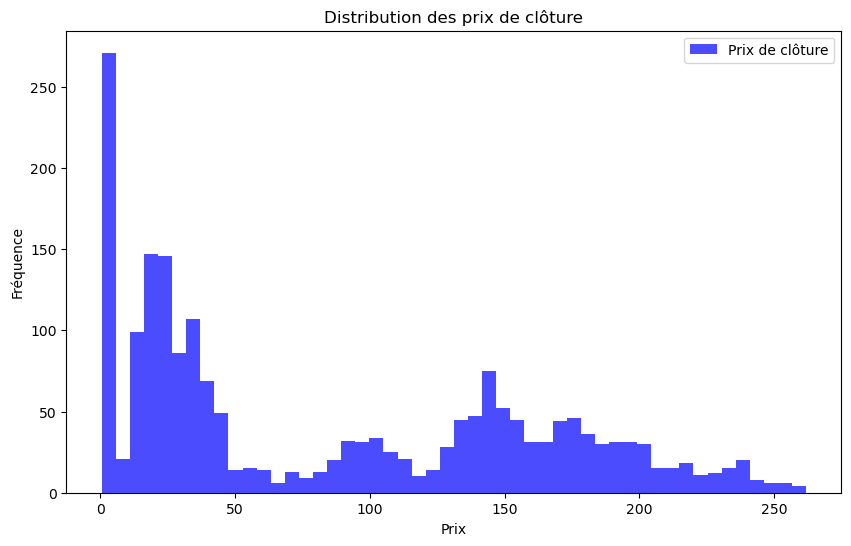

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=50, color='blue', alpha=0.7, label='Prix de clôture')
plt.title('Distribution des prix de clôture')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

#### Histogramme des volumes

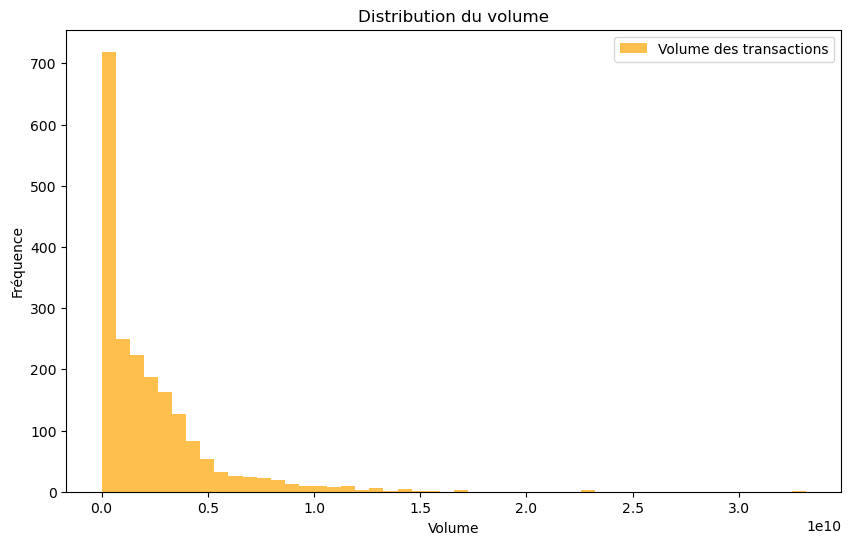

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(data['Volume'], bins=50, color='orange', alpha=0.7, label='Volume des transactions')
plt.title('Distribution du volume')
plt.xlabel('Volume')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

## Création d'un tableau interactif

In [12]:
from IPython.display import display

recent_data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_30', 'RSI', 'Bollinger_High', 'Bollinger_Low']].tail(10)
display(recent_data)

Price,Open,High,Low,Close,Volume,SMA_10,SMA_30,RSI,Bollinger_High,Bollinger_Low
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,
1988,182.036163,188.267883,182.023987,187.660294,4108902789,194.445119,212.241061,35.433967,247.930660,171.518019
1989,187.660294,192.200607,183.458252,187.798203,4863227045,191.125832,210.549244,35.218743,247.855582,169.067576
1990,187.798309,194.341156,184.046631,189.750671,6103945646,191.234512,208.887850,34.284416,247.783270,167.240644
1991,189.762039,197.374481,183.313248,185.666275,8186574439,191.995723,207.190878,36.411661,246.532605,164.890349
1992,185.667328,187.326630,177.673141,180.148132,7337365275,190.259682,205.845934,30.420506,242.895985,163.056095
1993,180.148132,193.175568,179.800873,191.388275,6358339771,188.561780,205.101633,38.449140,238.496431,163.294279
1994,191.388596,195.312332,189.108887,193.560226,5855077941,187.671768,204.495099,52.498505,234.641197,163.705216
1995,193.560822,195.083359,191.603333,194.040375,3170047006,187.673619,204.550419,59.097929,230.135141,164.755189
1996,194.037582,200.621216,192.160767,200.028625,4753310567,189.207587,204.372955,51.693826,224.104882,167.536707


In [13]:
data.columns = [col[0] for col in data.columns]  

print(data.head())


       Open      High       Low     Close   Volume    SMA_10    SMA_30  \
0  0.604042  0.625429  0.588448  0.604527  2128503  0.656959  0.674803   
1  0.604461  0.612303  0.513081  0.537034  2327581  0.641558  0.661003   
2  0.536255  0.571860  0.505194  0.515273  2098481  0.620206  0.652284   
3  0.513391  0.559759  0.505251  0.538576  2198625  0.602476  0.640820   
4  0.538372  0.564874  0.518038  0.550532  2326446  0.589575  0.633243   

         RSI  Bollinger_High  Bollinger_Low  
0  45.793690        0.751616       0.539154  
1  40.548006        0.751905       0.538687  
2  44.046391        0.760715       0.522639  
3  35.176061        0.759072       0.508979  
4  21.389646        0.760689       0.499669  


# Réalisation du Modèle RNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(50, return_sequences=False),
    Dropout(0.4),
    Dense(25),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 56, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,701 (131.64 KB)

 Trainable params: 33,701 (131.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0300 - val_loss: 0.0114
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025 - val_loss: 0.0042


#### Précision & Erreur MSE:

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")
print(f"Précision : {r2:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Erreur quadratique moyenne (MSE) : 0.0042
Précision : 0.7772


### Courbe de perte

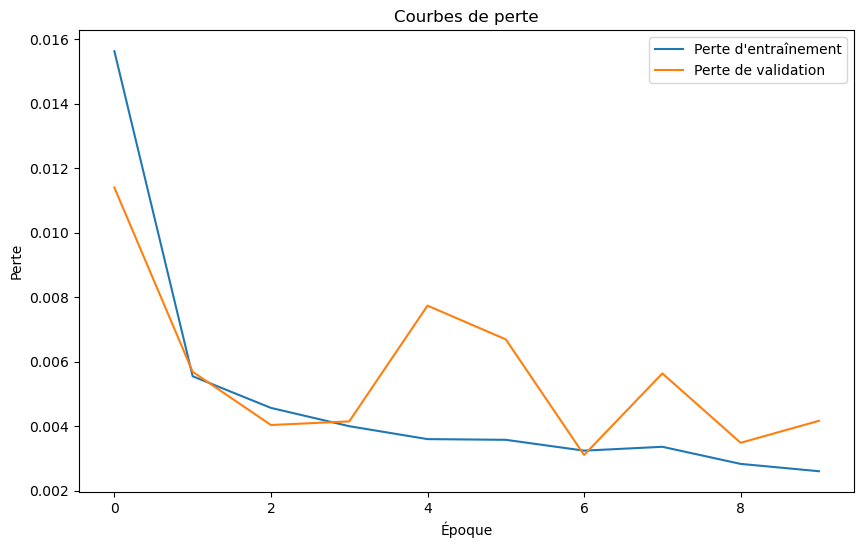

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Courbes de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()


#### Prédiction du Prochain jour (Prix de Clôture)

In [18]:
def predict_next_day(model, data, sequence_length):
    recent_data = data[-sequence_length:]  
    scaled_recent_data = np.array([recent_data]) 
    scaled_prediction = model.predict(scaled_recent_data)

    temp_array = np.zeros((1, scaled_data.shape[1]))
    temp_array[0, 3] = scaled_prediction[0][0] 
    prediction = scaler.inverse_transform(temp_array)[0, 3]
    return prediction

prediction = predict_next_day(model, scaled_data, sequence_length)
print(f"Prédiction pour le jour suivant : {prediction:.2f} USD")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prédiction pour le jour suivant : 177.47 USD
